In [36]:
%pip install opencv-python
%pip install matplotlib
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install torch torchvision torchaudio
%pip install joblib
%pip install pillow


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Load the Dataset using a Pytorch Data Loader

In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torchvision.models import ResNet18_Weights
import joblib

In [29]:
BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 1e-3
NUM_CLASSES = 5
IMAGE_SIZE = (256, 256)


def load_data(train_dir, test_dir, batch_size, img_size):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset.classes

train_dir = './images/Trains'
test_dir = './images/Tests'

# Load data
train_loader, test_loader, class_names = load_data(train_dir, test_dir, BATCH_SIZE, IMAGE_SIZE)

targets = [label for _, label in datasets.ImageFolder(train_dir).imgs]
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Defining the Model

In [30]:
class ResNet18CNN(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18CNN, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Add dropout layer and fully connected layers
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Training the Model

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18CNN(num_classes=NUM_CLASSES).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Epoch 1/60, Loss: 1.6062
Epoch 2/60, Loss: 1.4271
Epoch 3/60, Loss: 1.3664
Epoch 4/60, Loss: 1.2650
Epoch 5/60, Loss: 1.2081
Epoch 6/60, Loss: 1.1773
Epoch 7/60, Loss: 1.1489
Epoch 8/60, Loss: 1.1399
Epoch 9/60, Loss: 1.1533
Epoch 10/60, Loss: 1.1406
Epoch 11/60, Loss: 1.1511
Epoch 12/60, Loss: 1.1383
Epoch 13/60, Loss: 1.1403
Epoch 14/60, Loss: 1.1482
Epoch 15/60, Loss: 1.1479
Epoch 16/60, Loss: 1.1469
Epoch 17/60, Loss: 1.1377
Epoch 18/60, Loss: 1.1537
Epoch 19/60, Loss: 1.1540
Epoch 20/60, Loss: 1.1155
Epoch 21/60, Loss: 1.1376
Epoch 22/60, Loss: 1.1425
Epoch 23/60, Loss: 1.1428
Epoch 24/60, Loss: 1.1304
Epoch 25/60, Loss: 1.1424
Epoch 26/60, Loss: 1.1537
Epoch 27/60, Loss: 1.1647
Epoch 28/60, Loss: 1.1301
Epoch 29/60, Loss: 1.1469
Epoch 30/60, Loss: 1.1669
Epoch 31/60, Loss: 1.1313
Epoch 32/60, Loss: 1.1396
Epoch 33/60, Loss: 1.1423
Epoch 34/60, Loss: 1.1532
Epoch 35/60, Loss: 1.1490
Epoch 36/60, Loss: 1.1476
Epoch 37/60, Loss: 1.1435
Epoch 38/60, Loss: 1.1390
Epoch 39/60, Loss: 1.

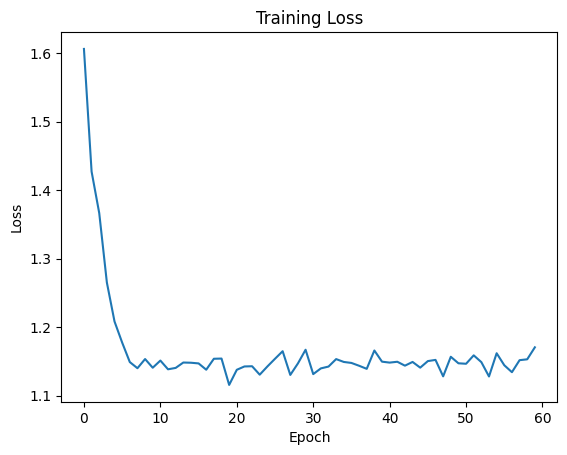

In [32]:
def train_model(model, train_loader, optimizer, loss_fn, epochs, device):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
        scheduler.step()

    # Plot loss curve
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

train_model(model, train_loader, optimizer, loss_fn, EPOCHS, device)

# Test the Model

In [33]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds.extend(outputs.argmax(1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(targets, preds, target_names=class_names))
    
evaluate_model(model, test_loader, device, class_names)

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.35      0.32        26
           1       0.29      0.23      0.26        26
           2       0.35      0.31      0.33        26
           3       0.69      0.85      0.76        26
           4       0.83      0.77      0.80        26

    accuracy                           0.50       130
   macro avg       0.49      0.50      0.49       130
weighted avg       0.49      0.50      0.49       130



In [ ]:
import joblib
from PIL import Image

# Load the model
model_path = './ResNet18_CNN_model.joblib'
model = joblib.load(model_path)
model.eval()  # Set the model to evaluation mode

# Define the class names
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

def preprocess_image(image_path, img_size):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

def predict_image_class(image_path):
    image = preprocess_image(image_path, IMAGE_SIZE)
    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        return class_names[predicted.item()]

# Example usage
image_path = './images/Tests/1/1020_left - Copy.jpeg'
prediction = predict_image_class(image_path)
print('Predicted class:', prediction)

Predicted class: Class 4


In [42]:
joblib_file = 'ResNet18_CNN_model.joblib'
joblib.dump(model, joblib_file)

['ResNet18_CNN_model.joblib']